<a href="https://colab.research.google.com/github/melancholymans/Predict_Future_Sales/blob/master/Predict_Future_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Future Sales
Final project for "How to win a data science competition" Coursera course
https://www.kaggle.com/c/competitive-data-science-predict-future-sales  

この課題は、「データサイエンスコンペティションの勝ち方」コースラコースの最終プロジェクトとして機能します。 このコンペティションでは、1C Companyというロシア最大のソフトウェア会社の1つによって親切に提供された、日々の売上データからなる困難な時系列データセットを使用します。 翌月のすべての商品と店舗の総売上を予測するようにお願いしています。 この競争を解決することによって、あなたはあなたのデータサイエンススキルを適用して向上させることができるでしょう。

## Loading Libraries and Data
Predict Future Sales Challengeへようこそ。このカーネルでは、例示的なデータの視覚化を行うことに焦点を当ててから、LSTMを使用して2015年11月の売上を予測します。

In [0]:
from google.colab import drive
drive.mount('/content/drive')

base_path = 'drive/My Drive/Colab Notebooks/kaggle/Predict_Future_Sales/'
base_input_path = 'drive/My Drive/Colab Notebooks/kaggle/Predict_Future_Sales/input/'
base_output_path = 'drive/My Drive/Colab Notebooks/kaggle/Predict_Future_Sales/output/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, date
# relativedeltaは時間の計算をするライブラリ
from dateutil.relativedelta import relativedelta
# 正規分布を使った正規化
from sklearn.preprocessing import StandardScaler

from math import ceil
# シンプルな自作コールバックを急いで作るためのコールバックです．
from keras.callbacks import LambdaCallback
# kerasのモデルのひとつ
from keras.models import Sequential
# Dense:通常の全結合ニューラルネットワークレイヤー
# keras.layers.Activation(activation) 出力に活性化関数を適用する
from keras.layers import Dense, Activation
# LSTMを用いた系列データ分類:
from keras.layers import LSTM
# オプティマイザ
from keras.optimizers import RMSprop

%matplotlib inline

train = pd.read_csv(base_input_path+'sales_train_v2.csv')
test = pd.read_csv(base_input_path+'test.csv')
submission = pd.read_csv(base_input_path+'sample_submission.csv')
items = pd.read_csv(base_input_path+'items.csv')
item_cats = pd.read_csv(base_input_path+'item_categories.csv')
shops = pd.read_csv(base_input_path+'shops.csv')

First we will check if all shop and items in the test set is also in the training set.  
最初に、テストセット内のすべてのショップとアイテムがトレーニングセットにも含まれているかどうかを確認します。

In [0]:
test_shops = test.shop_id.unique()
train = train[train.shop_id.isin(test_shops)]
print(train)
test_items = test.item_id.unique()
train = train[train.item_id.isin(test_items)]
print(train)

In [0]:
MAX_BLOCK_NUM = train.date_block_num.max()
MAX_ITEM = len(test_items)
MAX_CAT = len(item_cats)
MAX_YEAR = 3
MAX_MONTH = 4 # 7 8 9 10
MAX_SHOP = len(test_shops)
print('MAX_BLOCK_NUM : ',MAX_BLOCK_NUM)
print('MAX_ITEM : ',MAX_ITEM)
print('MAX_CAT : ',MAX_CAT)
print('MAX_YEAR : ',MAX_YEAR)
print('MAX_MONTH : ',MAX_MONTH)
print('MAX_SHOP : ',MAX_SHOP)

MAX_BLOCK_NUM :  33
MAX_ITEM :  5100
MAX_CAT :  84
MAX_YEAR :  3
MAX_MONTH :  4
MAX_SHOP :  42


## Data Exploration
Next, we would like to gain some insights about the data. I will attack from two angles, shop and item categories.  

次に、データについていくつか洞察を得たいと思います。 ショップとアイテムの2つの角度から攻撃します。


In [0]:
train.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935844,10.10.2015,33,25,7409,299.0,1.0
2935845,09.10.2015,33,25,7460,299.0,1.0
2935846,14.10.2015,33,25,7459,349.0,1.0
2935847,22.10.2015,33,25,7440,299.0,1.0
2935848,03.10.2015,33,25,7460,299.0,1.0


59
6


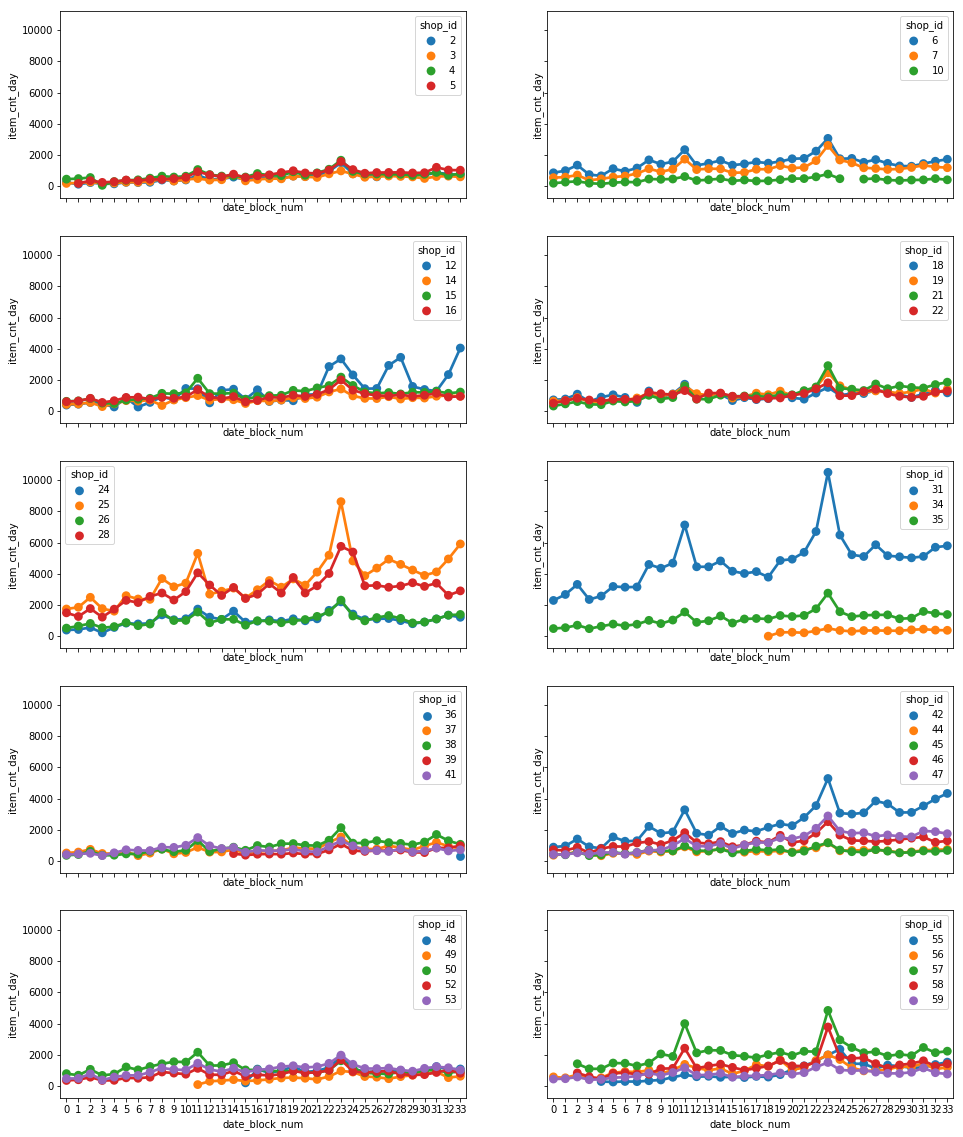

In [0]:
grouped = pd.DataFrame(train.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(grouped.shop_id.max() / num_graph)
print(grouped.shop_id.max())
print(id_per_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', 
                      hue='shop_id', data=grouped[np.logical_and(count*id_per_graph <= grouped['shop_id'], 
                                                                 grouped['shop_id'] < (count+1)*id_per_graph)], ax=axes[i][j])
        count += 1

勾配ベースの学習方法では、トレーニングをスピードアップするために数値変数を正規化するのが一般的です。

In [0]:
scaler = StandardScaler()
cnt_scaler = StandardScaler()
# trainのitem_price.as_matrix()ので配列に変換している
# reshape(-1,1)の-1は行数は推測してくださいという意味
scaler.fit(train.item_price.as_matrix().reshape(-1, 1))
cnt_scaler.fit(train.item_cnt_day.as_matrix().reshape(-1, 1))

train.item_price = scaler.transform(train.item_price.as_matrix().reshape(-1, 1))
train.item_cnt_day = cnt_scaler.transform(train.item_cnt_day.as_matrix().reshape(-1, 1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


ネットワークにフィードするためにトレーニングセット全体をエンコードしようとするのは自然です。 ただし、このアプローチには2つの欠点があります。2013年1月以降の販売データが2015年11月の販売に影響を与えることはほとんどありません。メモリ要件がKaggleの制限を超えています。 代わりに、2013年と2014年の7月、8月、9月、10月、11月の順序を学習します。

## 欠損データ
上記の期間内にすべての商品が売られるわけではありません。item_cnt_dayを0にして、それらの商品のレコードを追加します。価格は少しトリッキーです。 以下のコードで見られるように、アイテムの価格は店と時間の点に依存します。 空の値を最も近い過去のレコードで埋めます。

In [0]:
train.reset_index().groupby(['item_id', 'date_block_num', 'shop_id']).mean()

簡単にグループ化するために、グループ化の順序を少し変更します。

In [0]:
price = train.reset_index().set_index(['item_id', 'shop_id', 'date_block_num'])
price = price.sort_index()
price.head()

index        date  item_price  item_cnt_day
item_id shop_id date_block_num                                               
30      2       2                332029  01.03.2013   -0.367556     -0.096962
                5                575446  16.06.2013   -0.345667     -0.096962
                15              1585175  20.04.2014   -0.471530     -0.096962
                16              1653550  08.05.2014   -0.471530     -0.096962
        3       1                166771  23.02.2013   -0.345667     -0.096962

ヘルパー関数

In [0]:
def convert(date_block):
    date = datetime(2013, 1, 1)
    date += relativedelta(months = date_block)
    return (date.month, date.year)

def closest_date_block(current_day, item_id, shop_id):
    """Find the block_date which is closest to the current_day, given item_id and shop_id. Returns index integer"""
    if (item_id, shop_id) in price.index:
        search_lst = np.array(price.loc[(item_id, shop_id)].index)        
        return search_lst[np.abs(current_day - search_lst).argmin()]
    return -1
                
def closest_price(current_day, item_id, shop_id):
    closest_date = closest_date_block(current_day, item_id, shop_id)
    if closest_date != -1:
        return price.loc[( item_id, shop_id, closest_date )]['item_price']
    return np.nan

def closest_price_lambda(x):
    return closest_price(34, x.item_id, x.shop_id)

In [0]:
assert closest_date_block(18, 30, 5) == 18

In [0]:
# Some simple math to know what date_block_num to start learning
print(convert(6))
print(convert(18))
print(convert(30))

(7, 2013)
(7, 2014)
(7, 2015)


どのブロックをトレーニングするべきかを見つけるために、簡単な数学を行います。

In [0]:
maxlen = 4 # 4 months
step = 1
# 0: train, 1: val, 2:test
sentences = [[],[],[]]
next_chars = [[], []]
BLOCKS = [6, 18, 30]

for s in test_shops:
    shop_items = list(train.loc[s].index.get_level_values(0).unique())
    for it in shop_items:        
        for i_index, i in enumerate(BLOCKS):
            sentence = []
            closest_pc = closest_price(i, it, s)            
            for j in range(maxlen+1):
                if j < maxlen:
                    if (s, it, i+j) in train.index:
                        r = train.loc[(s, it, i + j)].to_dict(orient='list')                    
                        closest_pc = r['item_price'][0]
                        item_cnt_day = r['item_cnt_day'][0]
                        row = {'shop_id': s, 'date_block_num': i+j, 'item_cnt_day': item_cnt_day, 
                               'month': month, 'item_id': it, 'item_price': closest_pc, 'year': year}
                    else:
                        month, year = convert(i+j)                    
                        row = {'shop_id': s, 'date_block_num': i+j, 'item_cnt_day': 0, 
                               'month': month, 'item_id': it, 'item_price': closest_pc, 'year': year}
                    sentence.append(row)
                elif i_index < 2:   # not in test set
                    next_chars[i_index].append(row)
            sentences[i_index].append(sentence)

このコードが動かない

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
base_path = 'drive/My Drive/Colab Notebooks/kaggle/Predict_Future_Sales/'
base_input_path = 'drive/My Drive/Colab Notebooks/kaggle/Predict_Future_Sales/input/'
base_output_path = 'drive/My Drive/Colab Notebooks/kaggle/Predict_Future_Sales/output/'

次はここ
https://www.kaggle.com/dimitreoliveira/model-stacking-feature-engineering-and-eda

翌月のすべての商品と店舗の総売上を予測するようにお願いしています。 この競争を解決することによって、あなたはあなたのデータサイエンススキルを適用して向上させることができるでしょう。 あなたは毎日の過去の売上データを提供されます。 タスクは、テストセットの各店舗で販売されている製品の合計量を予測することです。 ショップや製品のリストは毎月わずかに変わることに注意してください。 このような状況に対処できる堅牢なモデルを作成することは、課題の一部です。

## データフィールドの説明：
ID  - テストセット内の（Shop、Item）  
タプルを表すID shop_id  - ショップの一意の識別子  
item_id  - 製品の一意の識別子item_category_id  - アイテムカテゴリの一意の識別子  date_block_num  - 連続する月の番号 便宜上。 2013年1月は0、2月2013は1、...、2015年10月は33 
date  -  dateの形式はdd / mm / yyyyです  
item_cnt_day  - 販売された商品の数。 このメジャーの月額を予測しています  
item_price  - アイテムの現在の価格  
item_name  - アイテムの名前  
shop_name  - ショップの名前  
item_category_name  - アイテムのカテゴリの名前

## import warningsの説明

警告メッセージは一般に、ユーザに警告しておいた方がよいような状況下にプログラムが置かれているが、その状況は (通常は) 例外を送出したりそのプログラムを終了させるほどの正当な理由がないといった状況で発されます。例えば、プログラムが古いモジュールを使っている場合には警告を発したくなるかもしれません。

Python プログラマは、このモジュールの warn() 関数を使って警告を発することができます。(C 言語のプログラマは PyErr_WarnEx() を使います; 詳細は 例外処理 を参照してください)。

## warnings.filterwarnings("ignore")
警告メッセージを出力するかどうかの決定は、警告フィルタによって制御されます。警告フィルタは一致規則 (matching rule)と動作からなるシーケンスです。 filterwarnings() を呼び出して一致規則をフィルタに追加することができ、 resetwarnings() を呼び出してフィルタを標準設定の状態にリセットすることができます。

## import catboostの説明
catboostとは？  
決定木ベースの勾配ブースティングに基づく機械学習ライブラリ。  
　最近、kaggleでも使われはじめられており、特徴としては以下のようだ。  
　　1. 回帰、分類の教師あり学習に対応  
　　2. kaggleで主流のxgboostとlightGBMと比較しても高い精度、学習速度を誇る  
　　3. GPU、マルチGPUに対応  
　　4. 幅広い言語対応（Python、R、C/C++）  
　　
　自身はkaggleの教師あり学習コンペはlightGBMを使っていたが、  
　性能が良いということなので一度触ってみる。  

## XGboostとは
XGboostは、アンサンブル学習がベースになっている手法です。
アンサンブル学習は、大きく2通りの方法があります。一つはバギングと呼ばれ、復元抽出によってたくさんモデルを作成し、それらを平均化する手法です。各モデルが無相関であれば、平均化によりモデルの平均誤差が1 / （モデルの数）になります。ランダムフォレストは、このバギングがベースになっています。ただし、各決定木ができるだけ独立になるよう、使う変数群もランダム抽出するなどの工夫がなられています。前回は、過学習気味である結果はあまり解消できませんでしたが、高い精度を持つモデルが構築できたのでした。

もう一つは、ブースティングと呼ばれ、モデルを逐次更新していく手法です。更新は、例えばAdaBoostと呼ばれる方法では、データにかける「重み」を前回作成したモデルをもとに変えることで行います。その際、作成したモデルの「正確さ」に対応するような重み係数も同時に算出し、最後に各モデルの予測値と重み係数をかけ合わせたものの和を、全体の予測値とします。

損失関数の最小化問題は、数理最適化問題であり、目的に応じて最小値を求めるための様々な手法があります。よく知られた（使われる）方法の一つに、損失関数の勾配情報（微分）を使ったアルゴリズムがあります*2。ブースティングで勾配情報を用いたアルゴリズムを用いているものを勾配ブースティングと呼び、それをC++で高速実装したものがXGboostです。

## sklearn.metrics  mean_squared_error
平均二乗誤差 (MSE)  
https://pythondatascience.plavox.info/scikit-learn/%E5%9B%9E%E5%B8%B0%E3%83%A2%E3%83%87%E3%83%AB%E3%81%AE%E8%A9%95%E4%BE%A1

平均二乗誤差 (MSE, Mean Squared Error) とは、実際の値と予測値の絶対値の 2 乗を平均したものです。この為、MAE に比べて大きな誤差が存在するケースで、大きな値を示す特徴があります。MAE と同じく、値が大きいほど誤差の多いモデルと言えます。計算式は以下となります。

evaluation_mse(evaluation_y: 実際の値, evaluation_y_hat: 予測値, evaluation_n: 件数)  

scikit-learn には、sklearn.metrics.mean_squared_error に計算用のメソッドが実装されており、以下のように利用できます。  

In [0]:
!pip install catboost

     |████████████████████████████████| 61.2MB 1.2MB/s 


In [0]:
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import catboost
from catboost import Pool
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

## Loading Data  

In [0]:
test = pd.read_csv(base_input_path + 'test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 'item_id': 'int32'})
item_categories = pd.read_csv(base_input_path + 'item_categories.csv', dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
items = pd.read_csv(base_input_path + 'items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 'item_category_id': 'int32'})
shops = pd.read_csv(base_input_path + 'shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})
sales = pd.read_csv(base_input_path + 'sales_train_v2.csv', parse_dates=['date'], 
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                          'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})

## Join data sets

### joinはmerge()と同じくデータ結合するメソッド。
join()はmerge()のようにpandas.join()関数は用意されておらず、pandas.DataFrameのメソッドだけなので注意。
merge()と異なり左結合（how='left'）がデフォルト。  
rsuffix ： str、デフォルトは ''
右フレームの重なっている列から使用する接尾辞。  

In [0]:
train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_') \
      .drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

In [0]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
1,2013-03-01,0,25,2552,899.00,1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
2,2013-05-01,0,25,2552,899.00,-1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
3,2013-06-01,0,25,2554,1709.05,1,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
4,2013-01-15,0,25,2555,1099.00,1,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства


In [0]:
print('Train rows: ', train.shape[0])
print('Train columns: ', train.shape[1])

Train rows:  2935849
Train columns:  10


In [0]:
train.head().T

,0,1,2,3,4
date,2013-02-01 00:00:00,2013-03-01 00:00:00,2013-05-01 00:00:00,2013-06-01 00:00:00,2013-01-15 00:00:00
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2552,2552,2554,2555
item_price,999.00,899.00,899.00,1709.05,1099.00
item_cnt_day,1,1,-1,1,1
item_name,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE Who Do You Think We Are LP,DEEP PURPLE 30 Very Best Of 2CD (Фирм.)
item_category_id,37,58,58,58,56
shop_name,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум"""
item_category_name,Кино - Blu-Ray,Музыка - Винил,Музыка - Винил,Музыка - Винил,Музыка - CD фирменного производства


## Time period of the dataset

In [0]:
print('Min date from train set: %s' % train['date'].min().date())
print('Max date from train set: %s' % train['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2015-12-10


## Data leakages
データ漏洩について私はテストセットに現れる "shop_id"と "item_id"のみを使用します。

In [0]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()
# Only shops that exist in test set.
lk_train = train[train['shop_id'].isin(test_shop_ids)]
# Only items that exist in test set.
lk_train = lk_train[lk_train['item_id'].isin(test_item_ids)]

In [0]:
print('Data set size before leaking:', train.shape[0])
print('Data set size after leaking:', lk_train.shape[0])

Data set size before leaking: 2935849
Data set size after leaking: 1224439


## Data cleaning

In [0]:
train = train.query('item_price > 0')

In [0]:
print('Data set size before leaking:', train.shape[0])

Data set size before leaking: 2935848


## データの前処理
私はテキスト機能を落としています。何もしないからです。 翌月のすべての商品と店舗の総売上を予測するよう求められ、データは日ごとに表示されるので、不要な列を削除して月ごとのデータを集計しましょう。

In [0]:
# Select only useful features.
train_monthly = lk_train[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]

In [0]:
train_monthly.shape

(1224439, 7)

In [0]:
# Group by month in this case "date_block_num" and aggregate features.
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
train_monthly = train_monthly.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})
# Rename features.
train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']

In [0]:
train_monthly.head(10)

,date_block_num,shop_id,item_category_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
0,0,2,2,5572,10730.00,1532.86,9,1.29,7
1,0,2,2,5643,4775.21,2387.60,0,0.00,2
2,0,2,5,5583,1188.30,594.15,2,1.00,2
3,0,2,6,7893,5970.00,1990.00,3,1.00,3
4,0,2,6,7894,1490.00,1490.00,1,1.00,1
5,0,2,6,7895,2697.00,899.00,4,1.33,3
6,0,2,6,7956,13780.00,6890.00,2,1.00,2
7,0,2,19,1409,1398.50,1398.50,1,1.00,1
8,0,2,19,1467,899.00,899.00,1,1.00,1
9,0,2,19,3076,1399.00,1399.00,1,1.00,1


In [0]:
train_monthly.tail(10)

,date_block_num,shop_id,item_category_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
600149,33,59,73,491,480.00,480.00,1,1.00,1
600150,33,59,73,792,979.00,979.00,1,1.00,1
600151,33,59,75,3014,1290.00,1290.00,1,1.00,1
600152,33,59,75,4178,3180.00,1590.00,3,1.50,2
600153,33,59,75,4181,9030.00,1290.00,7,1.00,7
600154,33,59,75,5383,4390.00,4390.00,1,1.00,1
600155,33,59,79,17717,8025.50,802.55,13,1.30,10
600156,33,59,83,22087,357.00,119.00,6,2.00,3
600157,33,59,83,22088,238.00,119.00,2,1.00,2
600158,33,59,83,22091,179.00,179.00,1,1.00,1


データの実際の動作を模倣するには、ロードされたデータセットから不足レコードを作成する必要があります。月ごとに、店舗や商品ごとに不足レコードを作成する必要があります。 0でそれらを。

In [0]:
# Build a data set with all the possible combinations of ['date_block_num','shop_id','item_id'] so we won't have missing records.
shop_ids = train_monthly['shop_id'].unique()
item_ids = train_monthly['item_id'].unique()
empty_df = []
for i in range(34):
    for shop in shop_ids:
        for item in item_ids:
            empty_df.append([i, shop, item])
    
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])

In [0]:
empty_df.head()

,date_block_num,shop_id,item_id
0,0,2,5572
1,0,2,5643
2,0,2,5583
3,0,2,7893
4,0,2,7894


In [0]:
# Merge the train set with the complete set (missing records will be filled with 0).
train_monthly = pd.merge(empty_df, train_monthly, on=['date_block_num','shop_id','item_id'], how='left')
train_monthly.fillna(0, inplace=True)

In [0]:
train_monthly.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
0,0,2,5572,2.00,10730.00,1532.86,9.00,1.29,7.00
1,0,2,5643,2.00,4775.21,2387.60,0.00,0.00,2.00
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00
3,0,2,7893,6.00,5970.00,1990.00,3.00,1.00,3.00
4,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00


In [0]:
train_monthly.shape

(6734448, 9)

In [0]:
# Extract time based features.
train_monthly['year'] = train_monthly['date_block_num'].apply(lambda x: ((x//12) + 2013))
train_monthly['month'] = train_monthly['date_block_num'].apply(lambda x: (x % 12))

In [0]:
train_monthly.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month
0,0,2,5572,2.00,10730.00,1532.86,9.00,1.29,7.00,2013,0
1,0,2,5643,2.00,4775.21,2387.60,0.00,0.00,2.00,2013,0
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00,2013,0
3,0,2,7893,6.00,5970.00,1990.00,3.00,1.00,3.00,2013,0
4,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00,2013,0


groupby を使うと、デフォルトでグループラベルが index になる。index にしたく無い場合は as_index=False を指定する。

In [0]:
# Grouping data for EDA.
gp_month_mean = train_monthly.groupby(['month'], as_index=False)['item_cnt'].mean()
gp_month_sum = train_monthly.groupby(['month'], as_index=False)['item_cnt'].sum()
gp_category_mean = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].mean()
gp_category_sum = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].sum()
gp_shop_mean = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
gp_shop_sum = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].sum()

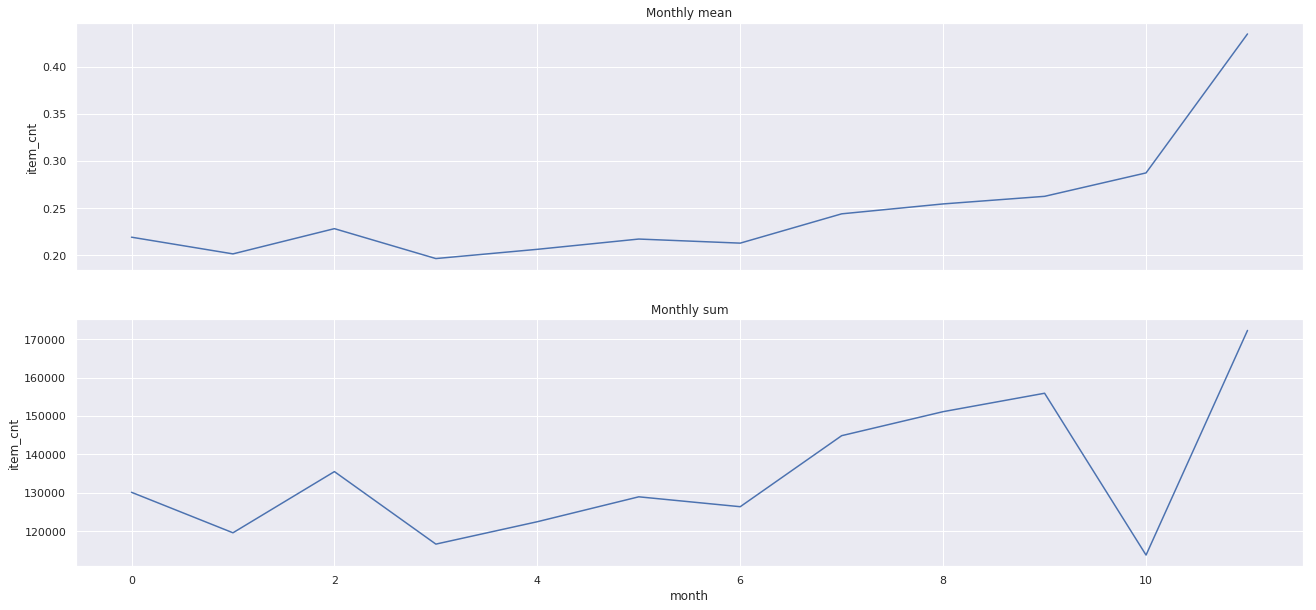

In [0]:
#売上は12月がTop
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.lineplot(x="month", y="item_cnt", data=gp_month_mean, ax=axes[0]).set_title("Monthly mean")
sns.lineplot(x="month", y="item_cnt", data=gp_month_sum, ax=axes[1]).set_title("Monthly sum")
plt.show()

ご覧のとおり、年末にかけて商品の販売数（平均）が増加傾向にあります。

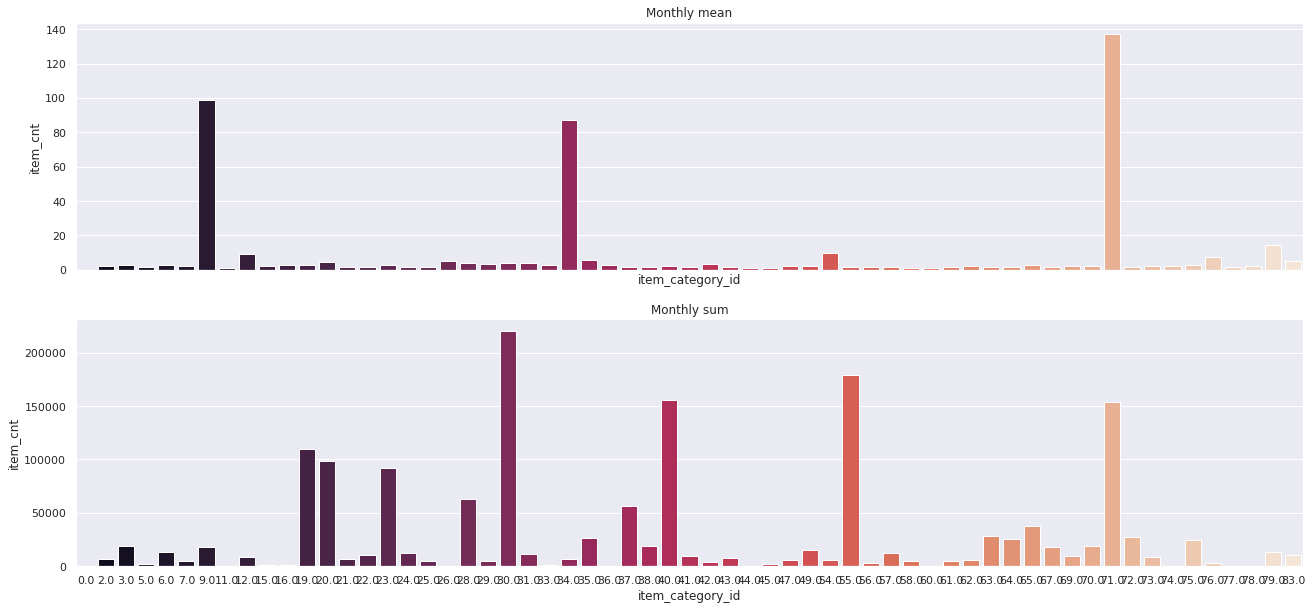

In [0]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

売り上げの大部分を占めるのは、ほんのわずかなカテゴリーだけです。

もっと売っている店は？

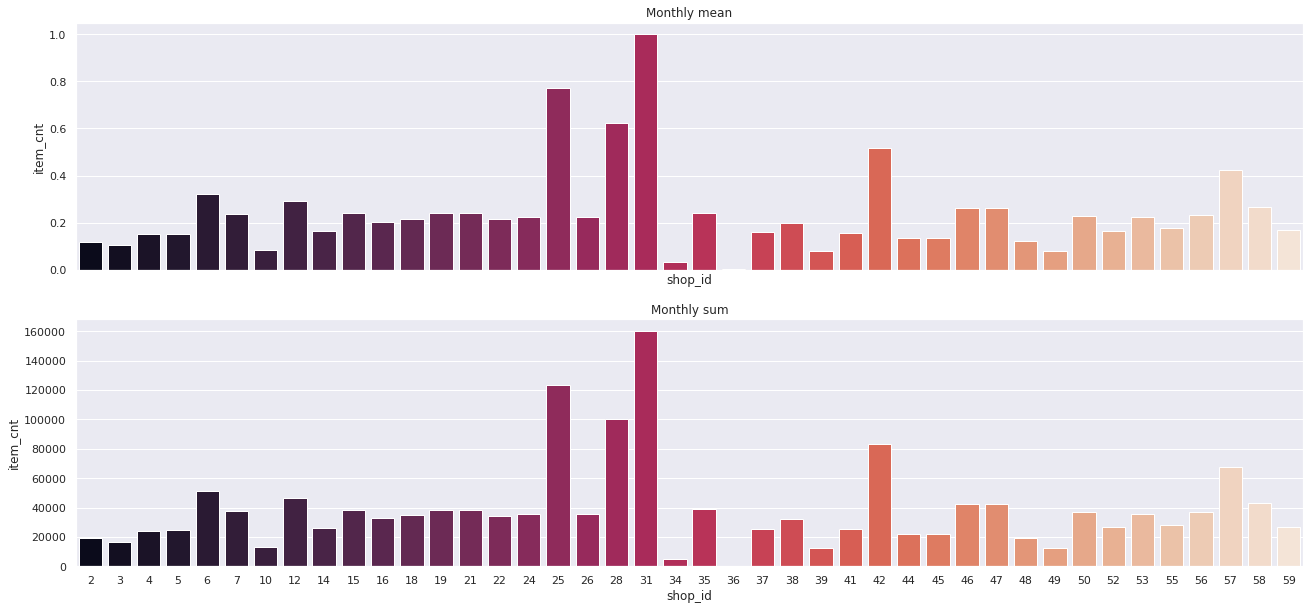

In [0]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

ほとんどの店は同じような売り率を持っていますが、そのうち3つはもっと高い率を持っています、これは店の大きさを示しているかもしれません。

外れ値をチェックする

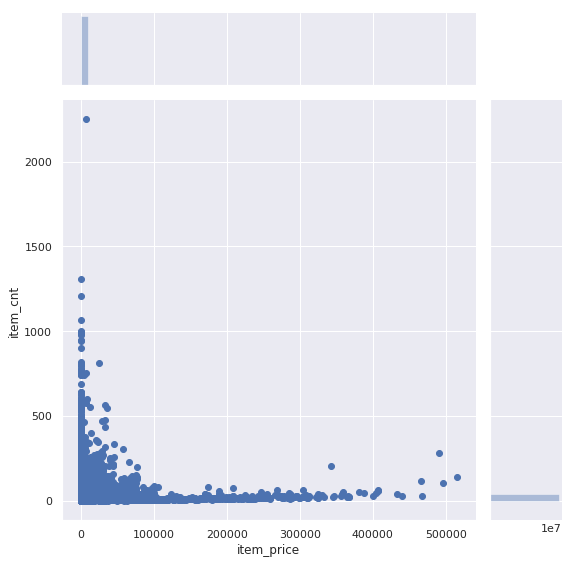

In [0]:
# ヒストグラムつきの散布図を作成する
#sns.jointplot(x="item_cnt", y="item_price", data=train_monthly, height=8)
sns.jointplot(y="item_cnt", x="item_price", data=train_monthly, height=8)
plt.show()

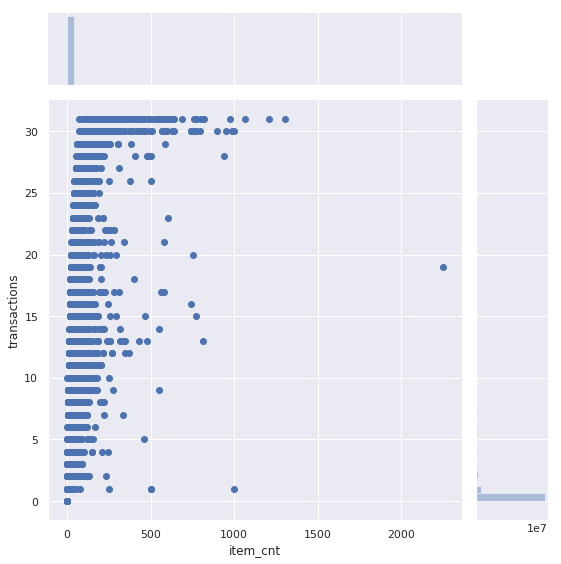

In [0]:
sns.jointplot(x="item_cnt", y="transactions", data=train_monthly, height=8)
plt.show()

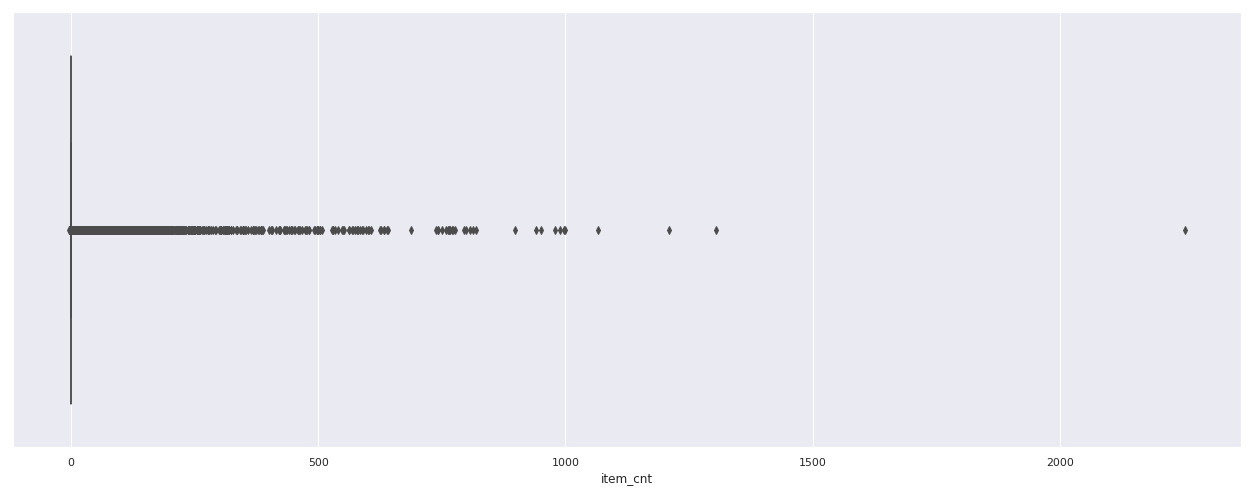

In [0]:
plt.subplots(figsize=(22, 8))
sns.boxplot(train_monthly['item_cnt'])
plt.show()

外れ値を削除する

In [0]:
train_monthly = train_monthly.query('item_cnt >= 0 and item_cnt <= 20 and item_price < 400000')

## ラベルの作成
私たちのラベルは翌月の "item_cnt"になるでしょう。予測問題を扱っているからです。

In [0]:
train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

In [0]:
train_monthly['item_price_unit'] = train_monthly['item_price'] // train_monthly['item_cnt']
train_monthly['item_price_unit'].fillna(0, inplace=True)